## Lab2 回归模型

- 姓名：于洋淼
- 学号：2113644
- 专业：物联网工程

### 实验要求
#### 基本要求
将数据集winequality-white.csv按照4:1划分为训练集和测试集。
1. 构造线性回归模型，并采用批量梯度下降**和**随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。
1. 对于批量梯度下降**和**随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。

特别需要注意：
- 划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。
- 需要对数据集进行一定的预处理

#### 中级要求
探究回归模型在机器学习和统计学上的差异。
- 回归模型在机器学习领域和统计学领域中都十分常用，而且使用方法也相似，但其实际的含义具有本质的区别。我们希望同学们从回归模型的角度更加充分地理解机器学习和统计学的区别。


#### 高级要求
编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法**均可**）。

### 导入需要的包

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import copy

### 数据预处理

In [32]:
data = pd.read_csv("winequality-white.csv")
data = data.dropna() # 删除有空值的行,不过其实没有空值
print(data)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  

#### 读取特征和结果

In [33]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
print(X)
print(y)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  

#### 归一化和标准化

In [34]:
# 归一化
def Normalization_fun(x):
    # 特征零均值
    x = (x - np.mean(x, 0)) / (np.max(x, 0) - np.min(x, 0))
    return x

# 标准化
def Standardization_fun(x):
    x = (x - np.mean(x, 0)) / np.std(x, 0)
    return x

X = Normalization_fun(X)
X = Standardization_fun(X)
print(X)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.172097         -0.081770     0.213280        2.821349  -0.035355   
1         -0.657501          0.215896     0.048001       -0.944765   0.147747   
2          1.475751          0.017452     0.543838        0.100282   0.193523   
3          0.409125         -0.478657    -0.117278        0.415768   0.559727   
4          0.409125         -0.478657    -0.117278        0.415768   0.559727   
...             ...               ...          ...             ...        ...   
4893      -0.776015         -0.677101    -0.365197       -0.944765  -0.310008   
4894      -0.301959          0.414339     0.213280        0.317179   0.056196   
4895      -0.420473         -0.379435    -1.191592       -1.023637  -0.218457   
4896      -1.605613          0.116674    -0.282557       -1.043355  -1.088192   
4897      -1.013043         -0.677101     0.378559       -1.102508  -1.179743   

      free sulfur dioxide  

## 基本要求

### 分割数据集
使用分层采样，按照4:1分割训练集和测试集

In [35]:
# 拼接回data
data = pd.concat([X, y], axis=1)
# 回归系数会比特征x多一维(截距项)，在左侧添加全为1的一列
data = pd.concat([pd.Series(1, index=data.index, name='intercept'), data], axis=1)

# 分层采样，按照4:1的比例划分训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['quality'], random_state=42)

train_x, train_y = train_data.iloc[:, :-1], train_data.iloc[:, -1]
test_x, test_y = test_data.iloc[:, :-1], test_data.iloc[:, -1]

train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()

train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

# 初始化回归系数
W_init = np.random.randn(train_x.shape[1], 1)
print(W_init)
print(W_init.shape)

[[-0.39396612]
 [ 1.66581547]
 [-0.3555093 ]
 [ 0.54995757]
 [ 0.39579612]
 [ 2.04692371]
 [ 1.15493504]
 [ 1.34020089]
 [-0.69756221]
 [ 0.61517072]
 [-1.59327749]
 [ 0.74069157]]
(12, 1)


### 计算MSE

In [36]:
# 预测函数
def predict(x, theta):
    y = 0
    for i in range(len(x) - 1):
        y += float(theta[i]) * float(x[i])
    return y

#计算均方误差
def MSE(theta, x, y):
    loss = 0
    for i in range(len(x)):
        temp = predict(x[i], theta) - y[i]
        loss += temp ** 2
    return loss / len(y)

### 批量梯度下降

In [37]:
# 批量梯度下降
def MyBGD(X, y, theta, lr, n_epochs):
    m = len(y)
    train_mse = []  # 用于存储 MSE 收敛曲线数据
    test_mse = []

    for epoch in range(n_epochs):
        gradients = (2/m) * X.T.dot(X.dot(theta) - y)
        theta = theta - lr * gradients

        train_e_mse = MSE(theta, X, y)
        test_e_mse = MSE(theta, test_x, test_y)
        print(f'Epoch [{epoch + 1}/{n_epochs}], Train MSE: {train_e_mse.item():.4f}, Test MSE: {test_e_mse.item():.4f}')
        train_mse.append(train_e_mse)
        test_mse.append(test_e_mse)
    return theta, train_mse, test_mse

In [38]:
epochs = 30
lr = 0.001
BGD_weights, BGD_train_mse, BGD_test_mse = MyBGD(train_x, train_y, W_init, lr, epochs)
print(BGD_weights)


Epoch [1/30], Train MSE: 54.8099, Test MSE: 57.3052
Epoch [2/30], Train MSE: 54.5654, Test MSE: 57.0494
Epoch [3/30], Train MSE: 54.3221, Test MSE: 56.7951
Epoch [4/30], Train MSE: 54.0803, Test MSE: 56.5421
Epoch [5/30], Train MSE: 53.8397, Test MSE: 56.2906
Epoch [6/30], Train MSE: 53.6005, Test MSE: 56.0404
Epoch [7/30], Train MSE: 53.3626, Test MSE: 55.7916
Epoch [8/30], Train MSE: 53.1260, Test MSE: 55.5442
Epoch [9/30], Train MSE: 52.8907, Test MSE: 55.2982
Epoch [10/30], Train MSE: 52.6567, Test MSE: 55.0534
Epoch [11/30], Train MSE: 52.4240, Test MSE: 54.8100
Epoch [12/30], Train MSE: 52.1925, Test MSE: 54.5680
Epoch [13/30], Train MSE: 51.9623, Test MSE: 54.3272
Epoch [14/30], Train MSE: 51.7333, Test MSE: 54.0878
Epoch [15/30], Train MSE: 51.5056, Test MSE: 53.8497
Epoch [16/30], Train MSE: 51.2791, Test MSE: 53.6128
Epoch [17/30], Train MSE: 51.0539, Test MSE: 53.3772
Epoch [18/30], Train MSE: 50.8298, Test MSE: 53.1429
Epoch [19/30], Train MSE: 50.6070, Test MSE: 52.9099
Ep

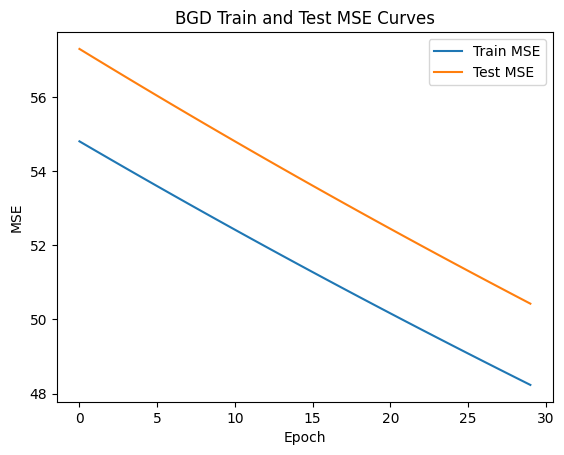

In [39]:
plt.plot(BGD_train_mse, label='Train MSE')
plt.plot(BGD_test_mse, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('BGD Train and Test MSE Curves')
plt.show()

### 随机梯度下降

In [40]:
# 随机梯度下降
def MySGD(X, y, theta, lr, n_epochs):
    m = len(y)
    train_mse = []  # 用于存储 MSE 收敛曲线数据
    test_mse = []

    for epoch in range(n_epochs):
        random_index = np.random.randint(m) # 随机选取一个样本(索引)
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        theta = theta - lr * gradients

        train_e_mse = MSE(theta, X, y)
        test_e_mse = MSE(theta, test_x, test_y)
        print(f'Epoch [{epoch + 1}/{n_epochs}], Train MSE: {train_e_mse.item():.4f}, Test MSE: {test_e_mse.item():.4f}')
        train_mse.append(train_e_mse)
        test_mse.append(test_e_mse)
    return theta, train_mse, test_mse

In [41]:
SGD_weights, SGD_train_mse, SGD_test_mse = MySGD(train_x, train_y, W_init, lr, epochs)

print(SGD_weights)

Epoch [1/30], Train MSE: 54.4873, Test MSE: 56.9644
Epoch [2/30], Train MSE: 54.2609, Test MSE: 56.7275
Epoch [3/30], Train MSE: 54.1622, Test MSE: 56.6439
Epoch [4/30], Train MSE: 54.1533, Test MSE: 56.6670
Epoch [5/30], Train MSE: 53.7088, Test MSE: 56.1968
Epoch [6/30], Train MSE: 53.6765, Test MSE: 56.1674
Epoch [7/30], Train MSE: 53.2809, Test MSE: 55.7439
Epoch [8/30], Train MSE: 53.1788, Test MSE: 55.6412
Epoch [9/30], Train MSE: 52.4915, Test MSE: 54.9293
Epoch [10/30], Train MSE: 52.3732, Test MSE: 54.8294
Epoch [11/30], Train MSE: 51.7311, Test MSE: 54.1527
Epoch [12/30], Train MSE: 51.3038, Test MSE: 53.6652
Epoch [13/30], Train MSE: 51.1529, Test MSE: 53.5024
Epoch [14/30], Train MSE: 50.9376, Test MSE: 53.2770
Epoch [15/30], Train MSE: 50.6834, Test MSE: 53.0065
Epoch [16/30], Train MSE: 50.1481, Test MSE: 52.3879
Epoch [17/30], Train MSE: 49.7840, Test MSE: 51.9936
Epoch [18/30], Train MSE: 49.1336, Test MSE: 51.3209
Epoch [19/30], Train MSE: 49.0178, Test MSE: 51.1962
Ep

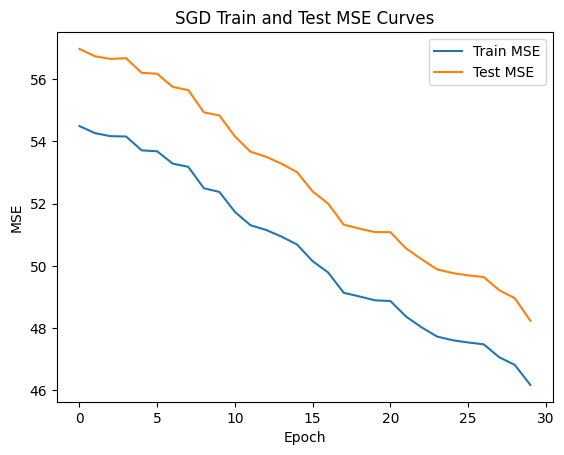

In [42]:
plt.plot(SGD_train_mse, label='Train MSE')
plt.plot(SGD_test_mse, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('SGD Train and Test MSE Curves')
plt.show()

### 测试不同学习率

#### 绘制不同学习率下两种梯度下降策略的Test MSE曲线

Epoch [1/30], Train MSE: 54.8099, Test MSE: 57.3052
Epoch [2/30], Train MSE: 54.5654, Test MSE: 57.0494
Epoch [3/30], Train MSE: 54.3221, Test MSE: 56.7951
Epoch [4/30], Train MSE: 54.0803, Test MSE: 56.5421
Epoch [5/30], Train MSE: 53.8397, Test MSE: 56.2906
Epoch [6/30], Train MSE: 53.6005, Test MSE: 56.0404
Epoch [7/30], Train MSE: 53.3626, Test MSE: 55.7916
Epoch [8/30], Train MSE: 53.1260, Test MSE: 55.5442
Epoch [9/30], Train MSE: 52.8907, Test MSE: 55.2982
Epoch [10/30], Train MSE: 52.6567, Test MSE: 55.0534
Epoch [11/30], Train MSE: 52.4240, Test MSE: 54.8100
Epoch [12/30], Train MSE: 52.1925, Test MSE: 54.5680
Epoch [13/30], Train MSE: 51.9623, Test MSE: 54.3272
Epoch [14/30], Train MSE: 51.7333, Test MSE: 54.0878
Epoch [15/30], Train MSE: 51.5056, Test MSE: 53.8497
Epoch [16/30], Train MSE: 51.2791, Test MSE: 53.6128
Epoch [17/30], Train MSE: 51.0539, Test MSE: 53.3772
Epoch [18/30], Train MSE: 50.8298, Test MSE: 53.1429
Epoch [19/30], Train MSE: 50.6070, Test MSE: 52.9099
Ep

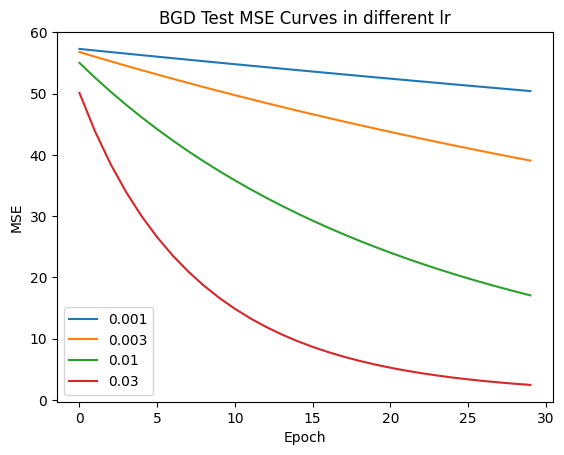

In [43]:
lr_arr = [0.001, 0.003, 0.01, 0.03]

BGD_test_mse_results = []  # 用于存储不同lr值下的BGD_test_mse

for lri in lr_arr:
    # 在每个lr值下运行MyBGD函数，并获得BGD_test_mse
    BGD_weights, BGD_train_mse, BGD_test_mse = MyBGD(train_x, train_y, W_init, lri, epochs)
    
    # 将BGD_test_mse添加到结果列表中
    BGD_test_mse_results.append(BGD_test_mse)

for i in range(len(lr_arr)):
    plt.plot(BGD_test_mse_results[i], label=lr_arr[i])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('BGD Test MSE Curves in different lr')
plt.show()

Epoch [1/30], Train MSE: 54.7599, Test MSE: 57.2325
Epoch [2/30], Train MSE: 54.2865, Test MSE: 56.7155
Epoch [3/30], Train MSE: 54.2010, Test MSE: 56.6298
Epoch [4/30], Train MSE: 54.0148, Test MSE: 56.4354
Epoch [5/30], Train MSE: 53.6633, Test MSE: 56.0736
Epoch [6/30], Train MSE: 53.6798, Test MSE: 56.0946
Epoch [7/30], Train MSE: 53.5752, Test MSE: 56.0211
Epoch [8/30], Train MSE: 53.4787, Test MSE: 55.9341
Epoch [9/30], Train MSE: 53.1929, Test MSE: 55.6214
Epoch [10/30], Train MSE: 53.0705, Test MSE: 55.5049
Epoch [11/30], Train MSE: 53.0863, Test MSE: 55.5544
Epoch [12/30], Train MSE: 52.9857, Test MSE: 55.4527
Epoch [13/30], Train MSE: 53.0389, Test MSE: 55.5083
Epoch [14/30], Train MSE: 53.0962, Test MSE: 55.5721
Epoch [15/30], Train MSE: 51.8587, Test MSE: 54.2344
Epoch [16/30], Train MSE: 51.4947, Test MSE: 53.8358
Epoch [17/30], Train MSE: 51.0504, Test MSE: 53.3430
Epoch [18/30], Train MSE: 51.0261, Test MSE: 53.3366
Epoch [19/30], Train MSE: 50.2928, Test MSE: 52.5532
Ep

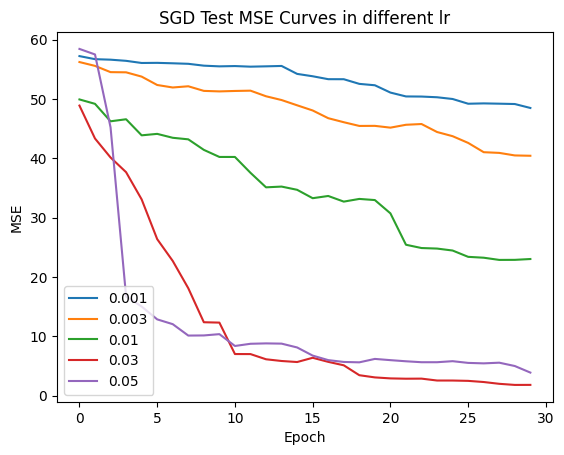

In [44]:
lr_arr = [0.001, 0.003, 0.01, 0.03, 0.05]

SGD_test_mse_results = []  # 用于存储不同lr值下的SGD_test_mse

for lri in lr_arr:
    # 在每个lr值下运行MySGD函数，并获得SGD_test_mse
    SGD_weights, SGD_train_mse, SGD_test_mse = MySGD(train_x, train_y, W_init, lri, epochs)
    
    # 将SGD_test_mse添加到结果列表中
    SGD_test_mse_results.append(SGD_test_mse)

for i in range(len(lr_arr)):
    plt.plot(SGD_test_mse_results[i], label=lr_arr[i])
# plt.plot(SGD_test_mse_results[2], label=lr_arr[2])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('SGD Test MSE Curves in different lr')
plt.show()

可以发现，随着学习率的增大，批量梯度下降和随机梯度下降的MSE均有大幅度降低，随机梯度下降法易出现抖动和噪音，批量梯度下降更平滑。

#### 寻找表现最好的学习率
学习率从0.05开始，每次乘0.9，小于0.001停止

In [45]:
lr_i = 0.05
best_lr = 0.05
min_mse = 50


while lr_i > 0.001:
    # 在每个lr值下运行MyBGD函数，并获得BGD_test_mse
    BGD_weights, BGD_train_mse, BGD_test_mse = MyBGD(train_x, train_y, W_init, lr_i, epochs)
    if min(BGD_test_mse) < min_mse:
        min_mse = min(BGD_test_mse)
        best_lr = lr_i
    lr_i = lr_i * 0.9
    
print(f'BGD, the best learning rate {best_lr}, the min mse {min_mse}')

Epoch [1/30], Train MSE: 43.5387, Test MSE: 45.5025
Epoch [2/30], Train MSE: 34.8914, Test MSE: 36.4551
Epoch [3/30], Train MSE: 28.2201, Test MSE: 29.4862
Epoch [4/30], Train MSE: 22.9791, Test MSE: 24.0202
Epoch [5/30], Train MSE: 18.8116, Test MSE: 19.6795
Epoch [6/30], Train MSE: 15.4709, Test MSE: 16.2028
Epoch [7/30], Train MSE: 12.7779, Test MSE: 13.4010
Epoch [8/30], Train MSE: 10.5982, Test MSE: 11.1329
Epoch [9/30], Train MSE: 8.8286, Test MSE: 9.2902
Epoch [10/30], Train MSE: 7.3883, Test MSE: 7.7890
Epoch [11/30], Train MSE: 6.2134, Test MSE: 6.5628
Epoch [12/30], Train MSE: 5.2533, Test MSE: 5.5591
Epoch [13/30], Train MSE: 4.4673, Test MSE: 4.7359
Epoch [14/30], Train MSE: 3.8226, Test MSE: 4.0593
Epoch [15/30], Train MSE: 3.2928, Test MSE: 3.5021
Epoch [16/30], Train MSE: 2.8568, Test MSE: 3.0424
Epoch [17/30], Train MSE: 2.4971, Test MSE: 2.6623
Epoch [18/30], Train MSE: 2.1999, Test MSE: 2.3474
Epoch [19/30], Train MSE: 1.9538, Test MSE: 2.0859
Epoch [20/30], Train MSE

In [46]:
lr_i = 0.05
best_lr = 0.05
min_mse = 50


while lr_i > 0.001:
    # 在每个lr值下运行MySGD函数，并获得SGD_test_mse
    SGD_weights, SGD_train_mse, SGD_test_mse = MySGD(train_x, train_y, W_init, lr_i, epochs)
    if min(SGD_test_mse) < min_mse:
        min_mse = min(SGD_test_mse)
        best_lr = lr_i
    lr_i = lr_i * 0.9
    
print(f'SGD, the best learning rate {best_lr}, the min mse {min_mse}')

Epoch [1/30], Train MSE: 84.1924, Test MSE: 81.5286
Epoch [2/30], Train MSE: 71.8922, Test MSE: 70.6983
Epoch [3/30], Train MSE: 70.3781, Test MSE: 69.4967
Epoch [4/30], Train MSE: 152.3996, Test MSE: 155.9015
Epoch [5/30], Train MSE: 93.0727, Test MSE: 96.7521
Epoch [6/30], Train MSE: 95.8898, Test MSE: 99.4427
Epoch [7/30], Train MSE: 80.9773, Test MSE: 84.2085
Epoch [8/30], Train MSE: 40.8872, Test MSE: 43.2142
Epoch [9/30], Train MSE: 41.7839, Test MSE: 44.0971
Epoch [10/30], Train MSE: 39.7288, Test MSE: 41.5209
Epoch [11/30], Train MSE: 41.4551, Test MSE: 40.1278
Epoch [12/30], Train MSE: 42.9980, Test MSE: 41.4529
Epoch [13/30], Train MSE: 40.9594, Test MSE: 40.2812
Epoch [14/30], Train MSE: 42.8288, Test MSE: 40.4151
Epoch [15/30], Train MSE: 41.8926, Test MSE: 38.1513
Epoch [16/30], Train MSE: 26.3990, Test MSE: 26.0815
Epoch [17/30], Train MSE: 26.1192, Test MSE: 26.4735
Epoch [18/30], Train MSE: 22.5200, Test MSE: 22.6741
Epoch [19/30], Train MSE: 19.1684, Test MSE: 19.4579


## 中级要求

### 探究回归模型在机器学习和统计学上的差异


1. **目的和重点**：
   - 机器学习：在机器学习中，回归模型通常用于预测和分类任务，其中主要关注预测模型的准确性。通常不过于关心参数的统计推断。
   - 统计学：在统计学中，回归模型用于理解变量之间的关系，估计参数的统计性质，进行假设检验和推断。统计学强调参数估计和对模型的拟合进行统计推断。

2. **数据处理**：
   - 机器学习：通常假设数据集是一个独立同分布的样本集，而且对数据的预处理要求通常较少，如处理缺失值或异常值。
   - 统计学：统计学通常更关注数据的质量和符合统计假设，可能需要更多的数据预处理和异常值处理。

3. **模型复杂性**：
   - 机器学习：机器学习方法通常更注重使用复杂的模型，如神经网络，支持向量机等，以获得更高的预测性能。
   - 统计学：统计学中的回归模型通常倾向于使用线性回归或广义线性模型等相对简单的模型，重点在参数的统计解释性。

4. **特征工程**：
   - 机器学习：在机器学习中，特征工程通常是关键步骤之一，它涉及选择、转换和创建特征以提高模型性能。
   - 统计学：统计学中特征工程的目标通常是为了理解特征对目标的影响，更侧重于建立可解释的模型。

5. **模型评估**：
   - 机器学习：机器学习中使用交叉验证和不同的评估指标来评估模型性能，如准确率、召回率、F1分数等。
   - 统计学：统计学中通常使用统计检验来检验模型的参数估计是否显著，并使用残差分析等方法来评估模型拟合的质量。

## 高级要求
实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法**均可**）。

### 岭回归算法

In [47]:
#岭回归算法
def MyRidge(X, y, alpha):
    # 将X和y转换为NumPy数组
    X = np.array(X)
    y = np.array(y)
    # 计算X的转置
    X_T = X.T
    # 计算X的形状
    m, n = X.shape
    # 构建岭回归的系数矩阵
    A = np.dot(X_T, X) + alpha * np.identity(n)
    # 构建岭回归的目标向量
    b = np.dot(X_T, y)
    # 使用线性代数库求解岭回归的参数估计
    theta = np.linalg.solve(A, b)

    return theta


#### 寻找表现最好的岭回归系数

In [48]:
alpha_arr = np.linspace(0.001,1)
best_alpha = 1
min_ridge_mse = 50

for alpha_i in alpha_arr:
    theta = MyRidge(train_x, train_y, alpha_i)
    test_ridge_mse = MSE(theta, test_x, test_y)
    train_ridge_mse = MSE(theta, train_x, train_y)
    print(f'alpha {alpha_i}, train mse {train_ridge_mse}, test mse {test_ridge_mse}')
    if test_ridge_mse < min_ridge_mse:
        best_alpha = alpha_i
        min_ridge_mse = test_ridge_mse

print(f'the best alpha of Ridge is {best_alpha}, mse is {min_ridge_mse}')
    

alpha 0.001, train mse [0.62236924], test mse [0.64248204]
alpha 0.021387755102040818, train mse [0.62238653], test mse [0.64250051]
alpha 0.041775510204081635, train mse [0.62240382], test mse [0.64251898]
alpha 0.062163265306122456, train mse [0.6224211], test mse [0.64253744]
alpha 0.08255102040816327, train mse [0.62243838], test mse [0.6425559]
alpha 0.10293877551020408, train mse [0.62245566], test mse [0.64257435]
alpha 0.12332653061224491, train mse [0.62247293], test mse [0.6425928]
alpha 0.1437142857142857, train mse [0.6224902], test mse [0.64261125]
alpha 0.16410204081632654, train mse [0.62250747], test mse [0.64262969]
alpha 0.18448979591836737, train mse [0.62252473], test mse [0.64264812]
alpha 0.20487755102040817, train mse [0.62254199], test mse [0.64266656]
alpha 0.225265306122449, train mse [0.62255924], test mse [0.64268499]
alpha 0.24565306122448982, train mse [0.62257649], test mse [0.64270341]
alpha 0.26604081632653065, train mse [0.62259374], test mse [0.642721